# Traing BERT sentiment analysis model

In [1]:
import nuclio

## Environment

In [ ]:
%nuclio config kind="job"
%nuclio config spec.image="mlrun/ml-models-gpu"
%nuclio cmd python -m pip install transformers==3.0.1 torch==1.6.0

## Function

In [3]:
#nuclio: start-code

In [2]:
import os
import pandas as pd
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertModel
import torch
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from collections import defaultdict
from mlrun.artifacts import PlotArtifact, ChartArtifact, TableArtifact
from mlrun.datastore import DataItem
from mlrun import MLClientCtx

In [3]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, pretrained_model, n_classes):
        super(BertSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(p=0.2)
        self.out_linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        out = self.dropout(pooled_out)
        out = self.out_linear(out)
        return self.softmax(out)

In [4]:
class ReviewsDataset(data.Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        enc = self.tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True)
        
        return {'input_ids': enc['input_ids'].squeeze(0), 
                'attention_mask': enc['attention_mask'].squeeze(0),
                'targets': torch.tensor(self.target[item], dtype=torch.long)}

In [5]:
def score_to_sents(score):
    if score <= 2:
        return 0
    if score == 3:
        return 1
    return 2

In [6]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = ReviewsDataset(
        review=df.content.to_numpy(),
        target=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    
    return data.DataLoader(dataset, batch_size=batch_size, num_workers=4)

In [7]:
def train_epoch(
    model,
    data_loader,
    criterion,
    optimizer,
    scheduler,
    n_examples,
    device
):
    model.train()
    losses = []
    correct_preds = 0
    
    for i, d in enumerate(data_loader):
        if i % 50 == 0:
            print(f'batch {i + 1}/ {len(data_loader)}')
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, pred = torch.max(outputs, dim=1)
        
        loss = criterion(outputs, targets)
        correct_preds += torch.sum(pred == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return (correct_preds.double() / n_examples).detach().cpu().numpy(), np.mean(losses)

In [8]:
def eval_model(
    model,
    data_loader,
    criterion,
    n_examples,
    device
):
    print('evaluation')
    model = model.eval()
    correct_preds = 0
    losses = []
    
    with torch.no_grad():
        for i, d in enumerate(data_loader):
            if i % 50 == 0:
                print(f'batch {i + 1}/ {len(data_loader)}')
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct_preds += torch.sum(pred == targets)
            losses.append(loss.item())
    return (correct_preds.double() / n_examples).detach().cpu().numpy(), np.mean(losses)

In [9]:
def eval_on_test(model_path, data_loader, device, n_examples, pretrained_model, n_classes):
    model = BertSentimentClassifier(pretrained_model, n_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct_preds = 0

    with torch.no_grad():
        for i, d in enumerate(data_loader):
            if i % 50 == 0:
                print(f'batch {i + 1}/ {len(data_loader)}')

            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)
            correct_preds += torch.sum(pred == targets)
    return correct_preds.double() / n_examples

In [10]:
def train_sentiment_analysis_model(context: MLClientCtx, 
                                   reviews_dataset: DataItem,
                                   pretrained_model: str = 'bert-base-cased', 
                                   models_dir: str = 'models',
                                   model_filename: str = 'bert_sentiment_analysis_model.pt',
                                   n_classes: int = 3,
                                   MAX_LEN: int = 128,
                                   BATCH_SIZE: int = 16,
                                   EPOCHS: int = 50,
                                   random_state: int = 42):

    # Check for CPU or GPU 
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    base_path = os.path.abspath(context.artifact_path)
    plots_path = os.path.join(base_path, 'plots')
    data_path = os.path.join(base_path, 'data')
    context.logger.info(f'Using {device}')
    
    models_basepath = os.path.join(context.artifact_path, models_dir)
    os.makedirs(models_basepath, exist_ok=True)
    model_filepath = os.path.join(models_basepath, model_filename)
    
    # Get dataset
    df = reviews_dataset.as_df()
    
    # Save score plot
    df = df[['content', 'score']]
    sns.distplot(df.score)
    reviews_scores_artifact = context.log_artifact(PlotArtifact(f"reviews-scores", body=plt.gcf()),
                                                   target_path=f"{plots_path}/reviews-scores.html")
    
    # Turn scores to sentiment label
    df['sentiment'] = df['score'].apply(score_to_sents)
    
    # Load bert tokenizer
    tokenizer = BertTokenizer.from_pretrained(pretrained_model)
    
    # Tokenize reviews
    lens = [len(tokenizer.encode(df.loc[review]['content'])) for review in df.index]
    max_length = max(lens)
    context.logger.info(f'longest review: {max_length}')
    plt.clf()
    sns.distplot(lens)
    reviews_lengths_artifact = context.log_artifact(PlotArtifact(f"reviews-lengths", body=plt.gcf()),
                                                    target_path=f"{plots_path}/reviews-lengths.html")
    
    # Create training and validation datasets
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
    df_dev, df_test = train_test_split(df_test, test_size = 0.5, random_state=random_state)
    
    # Create dataloaders for all datasets
    train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    dev_loader = create_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE)
    test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
    
    # Load the bert sentiment classifier base
    model = BertSentimentClassifier(pretrained_model, n_classes=n_classes).to(device)
    
    # training
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_acc = train_acc = train_loss = dev_acc = dev_loss = 0

    context.logger.info('Started training the model')
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            scheduler,
            len(df_train),
            device
        )
        
        dev_acc, dev_loss = eval_model(
            model,
            dev_loader,
            criterion,
            len(df_dev),
            device
        )

        # Append results to history
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['dev_acc'].append(dev_acc)
        history['dev_loss'].append(dev_loss)
        context.logger.info(f'Epoch: {epoch + 1}/{EPOCHS}: Train loss: {train_loss}, accuracy: {train_acc} Val loss: {dev_loss}, accuracy: {dev_acc}')

        if dev_acc > best_acc:
            torch.save(model.state_dict(), model_filepath)
            context.logger.info(f'Updating model, Current models is better then the previous one ({best_acc} vs. {dev_acc}).')
            best_acc = dev_acc
    
    context.logger.info('Finished training, testing and logging results')
    chart = ChartArtifact('summary')
    chart.header = ['epoch', 'accuracy', 'val_accuracy', 'loss', 'val_loss']
    for i in range(len(history['train_acc'])):
        chart.add_row([i + 1, history['train_acc'][i],
                       history['train_loss'][i],
                       history['dev_acc'][i],
                       history['dev_loss'][i]])
    summary = context.log_artifact(chart, local_path=os.path.join('plots', 'summary.html'))

    history_df = pd.DataFrame(history)
    history_table = TableArtifact('history', df=history_df)
    history_artifact = context.log_artifact(history_table, target_path=os.path.join(data_path, 'history.csv'))

    test_acc = eval_on_test(model_filepath, test_loader, device, len(df_test), pretrained_model, n_classes)
    context.logger.info(f'Received {test_acc} on test dataset')
    results = {'train_accuracy': train_acc,
               'train_loss': train_loss,
               'best_acccuracy': best_acc,
               'validation_accuracy': dev_acc,
               'validation_loss': dev_loss}
    context.log_results(results)
    context.log_model(key='bert_sentiment_analysis_model',
                      model_file=model_filename,
                      model_dir=models_dir,
                      artifact_path=context.artifact_path,
                      upload=False,
                      labels={'framework': 'pytorch',
                              'category': 'nlp',
                              'action': 'sentiment_analysis'},
                      metrics=context.results,
                      parameters={'pretrained_model': pretrained_model,
                                  'MAX_LEN': MAX_LEN,
                                  'BATCH_SIZE': BATCH_SIZE,
                                  'EPOCHS': EPOCHS,
                                  'random_state': random_state},
                      extra_data={'reviews_scores': reviews_scores_artifact,
                                  'reviews_length': reviews_lengths_artifact,
                                  'training_history': history_artifact})
    

In [11]:
#nuclio: end-code

## Test locally

> 2021-01-13 18:09:40,011 [warning] artifact path is not defined or is local, artifacts will not be visible in the UI
> 2021-01-13 18:09:40,021 [info] starting run mlrun-5d96ef-train_sentiment_analysis_model uid=788b811105bb454aa2536200c16c4700 DB=http://mlrun-api:8080
> 2021-01-13 18:09:40,112 [info] Using cpu


/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


> 2021-01-13 18:09:40,555 [info] longest review: 170
> 2021-01-13 18:09:44,197 [info] Started training the model
batch 1/ 5
evaluation
batch 1/ 1
> 2021-01-13 18:10:00,530 [info] Epoch: 1/1: Train loss: 0.9057091355323792, accuracy: 0.9625 Val loss: 0.7658687829971313, accuracy: 1.0
> 2021-01-13 18:10:04,511 [info] Updating model, Current models is better then the previous one (0 vs. 1.0).
> 2021-01-13 18:10:04,511 [info] Finished training, testing and logging results
batch 1/ 1
> 2021-01-13 18:10:09,822 [info] Received 1.0 on test dataset


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...c16c4700,0,Jan 13 18:09:40,completed,mlrun-5d96ef-train_sentiment_analysis_model,v3io_user=orzkind=handlerowner=orzhost=jupyter-orz-64d5b89f5d-x4spl,reviews_dataset,pretrained_model=bert-base-casedEPOCHS=1,train_accuracy=0.9625train_loss=0.9057091355323792best_acccuracy=1.0validation_accuracy=1.0validation_loss=0.7658687829971313,reviews-scoresreviews-lengthssummaryhistorybert_sentiment_analysis_model


to track results use .show() or .logs() or in CLI: 
!mlrun get run 788b811105bb454aa2536200c16c4700 --project default , !mlrun logs 788b811105bb454aa2536200c16c4700 --project default
> 2021-01-13 18:10:10,105 [info] run executed, status=completed


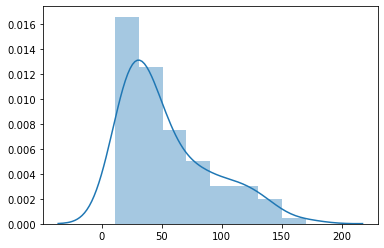

In [12]:
from mlrun import code_to_function, mount_v3io, run_local, NewTask

reviews_datafile = os.path.join(os.path.abspath('..'), 'data', 'reviews.csv')
pretrained_model = 'bert-base-cased'

task = NewTask(params={'pretrained_model': pretrained_model,
                       'EPOCHS': 1},
               inputs={'reviews_dataset': reviews_datafile})
lrun = run_local(task, handler=train_sentiment_analysis_model)

## Deploy to cluster

In [17]:
fn = code_to_function(name='train_sentiment_analysis',
                      project='stocks',
                      handler='train_sentiment_analysis_model')
fn.gpus(1)
fn.export('bert_sentiment_classification.yaml')
fn.apply(mount_v3io())

> 2020-10-14 09:55:39,793 [info] function spec saved to path: bert_sentiment_classification.yaml


In [18]:
run = fn.with_code().run(task, artifact_path='/User/stock-trading/')

> 2020-10-14 08:38:17,960 [info] starting run train-sentiment-analysis-train_sentiment_analysis_model uid=cc7a4299758244f6a51574bc2db371f9  -> http://mlrun-api:8080
> 2020-10-14 08:38:18,106 [info] Job is running in the background, pod: train-sentiment-analysis-train-sentiment-analysis-model-8q2s9
Downloading: 100%|██████████| 213k/213k [00:00<00:00, 496kB/s]  
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Downloading: 100%|██████████| 433/433 [00:00<00:00, 274kB/s]
Downloading: 100%|██████████| 436M/436M [00:11<00:00, 38.2MB/s] 
> 2020-10-14 08:38:28,729 [info] Using cuda:0
> 2020-10-14 08:38:43,330 [info] longest review: 520
> 2020-10-14 08:39:02,284 [info] Started traini

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
stocks,...2db371f9,0,Oct 14 08:38:28,completed,train-sentiment-analysis-train_sentiment_analysis_model,v3io_user=adminkind=jobowner=adminhost=train-sentiment-analysis-train-sentiment-analysis-model-8q2s9,reviews_dataset,pretrained_model=bert-base-casedEPOCHS=2,train_accuracy=0.7526992696093998train_loss=0.7954725730540183best_acccuracy=0.7263492063492063validation_accuracy=0.7263492063492063validation_loss=0.8184037906954987,reviews-scoresreviews-lengthssummaryhistorybert_sentiment_analysis_model


to track results use .show() or .logs() or in CLI: 
!mlrun get run cc7a4299758244f6a51574bc2db371f9 --project stocks , !mlrun logs cc7a4299758244f6a51574bc2db371f9 --project stocks
> 2020-10-14 08:58:11,565 [info] run executed, status=completed
